# Project Overview

## Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
#Importing all the required libraries
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
import os
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import warnings
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
warnings.filterwarnings('ignore')



In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
import sys
print(sys.version)

3.6.10 |Anaconda custom (64-bit)| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]


# Problem Statement

1) Determine which demographic groups, i.e.age, gender and income groups, respond best to the offer types. 

2) Assess characteristics of the demographic groups who respond the least to offers

3) Build a model to predict what features affect a user's response to an offer. 

# Metrics
Business question 3 is a classification problem. Hence, Accuracy and F1 score Metrics will be used to to measure performance of the models.

# 1. Data Exploration

### 1.1 Loading the datasets

In [5]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [7]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


Let's determine the shape of our datasets.

In [8]:
portfolio.shape

(10, 6)

In [9]:
transcript.shape

(306534, 4)

In [10]:
profile.shape

(17000, 5)

In [11]:
#baseline descriptive statistics for the numerical variables in the data
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [12]:
#baseline descriptive statistics for the numerical variables in the data
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
#baseline descriptive statistics for the numerical variables in the data
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# 2. Data Transformation
The next steps is data cleaning i.e dealing with missing values, duplicates, create dummies for categorical variables and datatype tranformation

In [14]:
#For cleaning the portfolio dataset, we have to take the following steps below:

# Change the name of the 'id' column to 'offer_id'
portfolio.rename(columns={"id": "offer_id"}, inplace = True)

# One-Hot encode the 'channels' columns
channels = ['web', 'email', 'mobile', 'social']
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1

#transform offer duration days to hours
portfolio['duration']=portfolio['duration']*24


# Drop the "channels" column
portfolio = portfolio.drop(columns=['channels'])

portfolio.head(10)

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [15]:
#Check for missing values in the dataset
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   offer_type  10 non-null     object
 4   offer_id    10 non-null     object
 5   web         10 non-null     int32 
 6   email       10 non-null     int32 
 7   mobile      10 non-null     int32 
 8   social      10 non-null     int32 
dtypes: int32(4), int64(3), object(2)
memory usage: 688.0+ bytes


There are no missing values in the portfolio dataset. Next, we move on to cleaning other datasets.

In [16]:
#Check for missing values in the dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


There are the same amount of missing values for gender and income in the profile dataset.Let's explore this further to determine if we will impute a mean/ median or remove the missing values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D66D038630>,
      dtype=object)

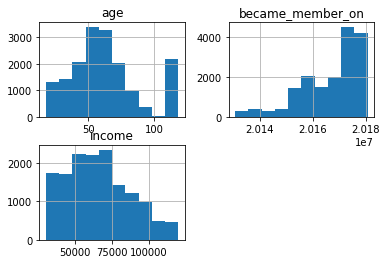

In [17]:
#Run some data exploration to understand the profile data
profile.hist()

Age has an outlier in the histogram distribution. let's explore this further.

In [18]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

The maximum age is 118 which is not realistic. Let us check what are the values for Gender and Income, when age is 118

In [19]:
#checking the values for gender and income when age=118
profile[['gender','income','age']][profile['age']==118].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


In [20]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [21]:
#check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The missing values for age and gender is equal to the value counts when age is 118. Could there be a connection between these three variables. Let's examine the values of income and gender when age is 118.

In [22]:
#Check when age is 118 and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


Yes, there is a connection. This means that if we remove all the values when age is 118, then there will be no missing values for gender and income. we shall begin the cleaning process for the profile dataset.

In [23]:
#For cleaning the profile dataset, we have to take the following steps below:
# Change the name of the id column to customerid
profile.rename(columns={"id": "customerid"}, inplace = True)

# Convert outlier value encoded as 118 to N/A in the age column
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

# drop all missing values
profile.dropna(inplace=True)
profile = profile.reset_index(drop=True)

# extract the year that users became members and number of days since the user signed up using the current day as reference
profile['start_year'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year
profile['membership_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['membership_days'] = profile['membership_days'].dt.days

#drop 'became_member_on'
profile = profile.drop(columns=['became_member_on'])


profile.head()

,gender,age,customerid,income,start_year,membership_days
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1077
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1144
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,2018,792
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,868
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,958


In [24]:
#updated number of columns and rows after removing age= 118
profile.shape

(14825, 6)

In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There are no missing values in the transcript dataset.

In [26]:
#For cleaning the transcript dataset, we have to take the following steps below:
# Change the name of the 'person' column to 'customerid'

transcript.rename(columns={"person": "customerid"}, inplace = True)

# Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customerid'].isin(profile['customerid'])]

# Expand the value column to create offer_id, amount and reward columns
transcript =pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript = transcript.drop(columns=['value'])


transcript = transcript.reset_index(drop=True)
transcript.head(10)

,customerid,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


We have to further clean the transcript dataset because it has two offer id columns.

In [27]:
#combine the 2 offer id columns into one using the def function
def merge_cols(row):
    if pd.isnull(row['offer id']):
        val = row['offer_id']
    else:
        val = row['offer id']
    return val

#Applying the function to create offer_id_new column
transcript['offer_id_new'] = transcript.apply(merge_cols, axis=1)
transcript.head(10)

,customerid,event,time,offer id,amount,offer_id,reward,offer_id_new
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [28]:
#Dropping offer id and offer_id column
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)
#Renaming offer_id_new column to offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [29]:
transcript.head(10)

,customerid,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,31dda685af34476cad5bc968bdb01c53,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,f806632c011441378d4646567f357a21,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


# 3. Data Visualization
## 3a. Visualization of the profile data
The next step is to visualize the data after cleaning

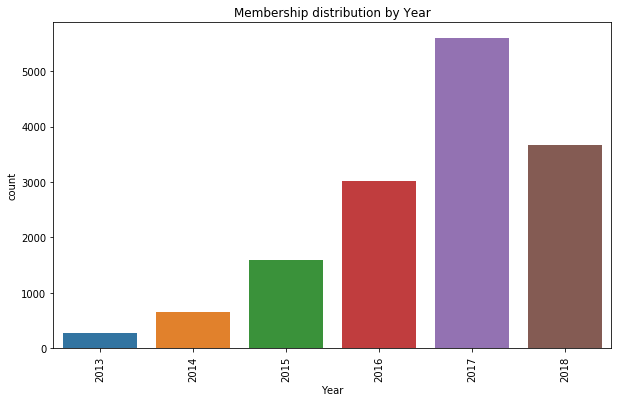

In [30]:
#Plotting membership distribution
plt.figure(figsize=(10, 6))
sns.countplot(profile['start_year'])
plt.title('Membership distribution by Year')
plt.xlabel('Year')
plt.xticks(rotation = 90)
plt.show();

2017 was the year where most of the app users became members while 2013 was the year with the least members.

Text(0.5,1,'Gender distribution by members')

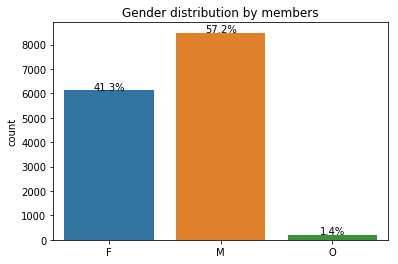

In [31]:
#Plotting Gender distribution
ax = sns.countplot(x="gender", data=profile)
total = float(len(profile))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
    
ax.set_xlabel('')
ax.set_ylabel('count')
ax.set_title('Gender distribution by members')

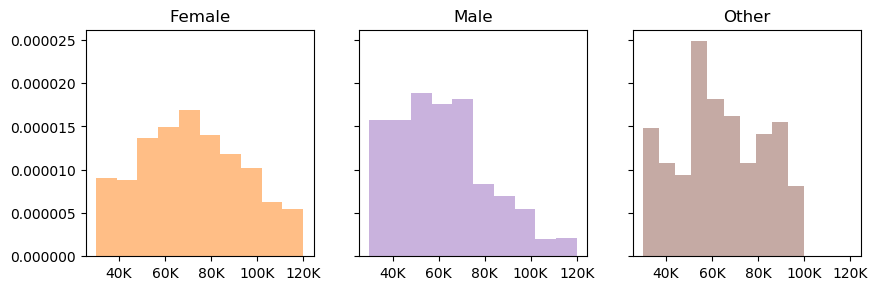

In [32]:
#Creating a function to format of income labels into ranges
def income(x, position):
    'The two args are the value and tick position'
    return '{:1.0f}K'.format(x*1e-3)

#creating a function to change the gender labels
def labels(gender): 
    if gender == "M": 
        label = 'Male'
    elif gender == "F": 
        label = 'Female'
    else: 
        label ='Other'
    return label

#Gender distribution by income 
fig, axes = plt.subplots(1, 3, figsize=(10,3), dpi=100, sharex=True, sharey=True)
colors = ['tab:orange', 'tab:purple', 'tab:brown']

for i, (ax, gender) in enumerate(zip(axes.flatten(), profile.gender.unique())):
    x = profile.loc[profile.gender==gender, 'income']
    ax.xaxis.set_major_formatter(plt.FuncFormatter(income))
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True, label=str(gender), color=colors[i])
    ax.set_title(labels(gender))

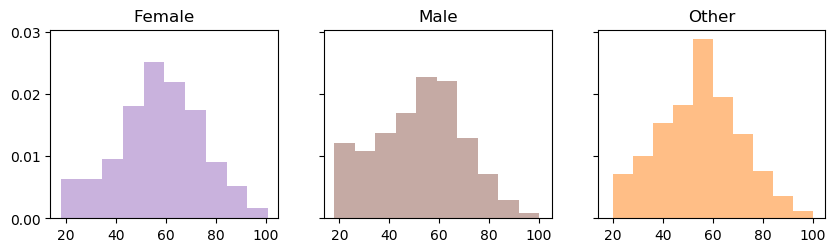

In [33]:
#Gender Distribution by age
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:purple', 'tab:brown', 'tab:orange']
for i, (ax, gender) in enumerate(zip(axes.flatten(), profile.gender.unique())):
    x = profile.loc[profile.gender==gender, 'age']
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True,  color=colors[i])
    ax.set_title(labels(gender))


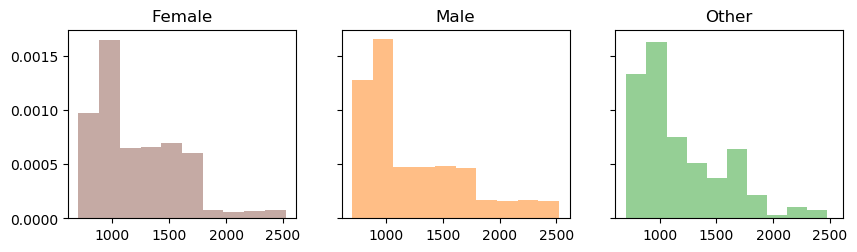

In [34]:
#Gender distribution by membership days
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:brown', 'tab:orange', 'tab:green']
for i, (ax, gender) in enumerate(zip(axes.flatten(), profile.gender.unique())):
    x = profile.loc[profile.gender==gender, 'membership_days']
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True,  color=colors[i])
    ax.set_title(labels(gender))

## 3b. Visualization of the Transcript data

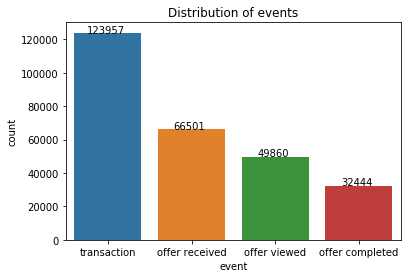

In [35]:
#bar chart distribution of event
ax = sns.countplot(transcript['event'], 
                   order = transcript['event'].value_counts().index)
for p, label in zip(ax.patches, transcript['event'].value_counts().values):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15),ha = 'center')
    ax.set_title('Distribution of events')

Text(0.5,1,'Offer_ids with Completed Status')

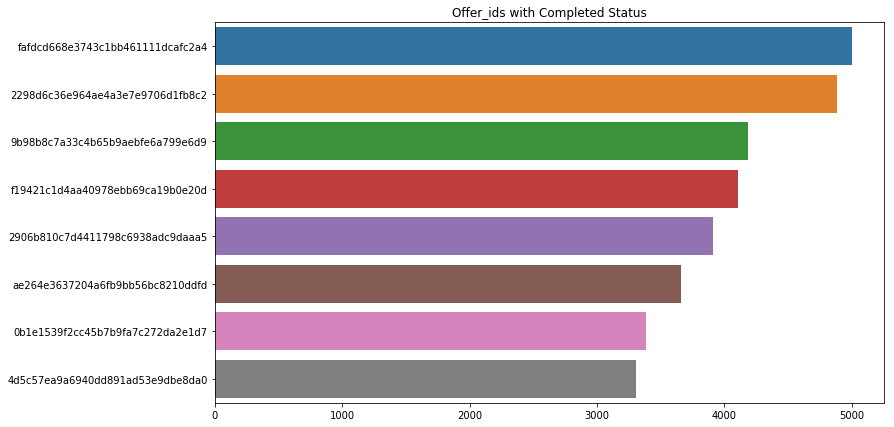

In [36]:
#check offer_ids that were completed
completed_offers = transcript[transcript['event']=='offer completed']
completed_offers['offer_id'].value_counts()
#plot a bar chart to show the distribution
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=completed_offers, order = completed_offers['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Offer_ids with Completed Status')

From the graph, we see that offer id 'fafdcd668e3743c1bb461111dcafc2a4' has the highest completed status while offer id '4d5c57ea9a6940dd891ad53e9dbe8da0' has the lowest completed status.

Text(0.5,1,'Offer_ids Received by Starbucks App Users')

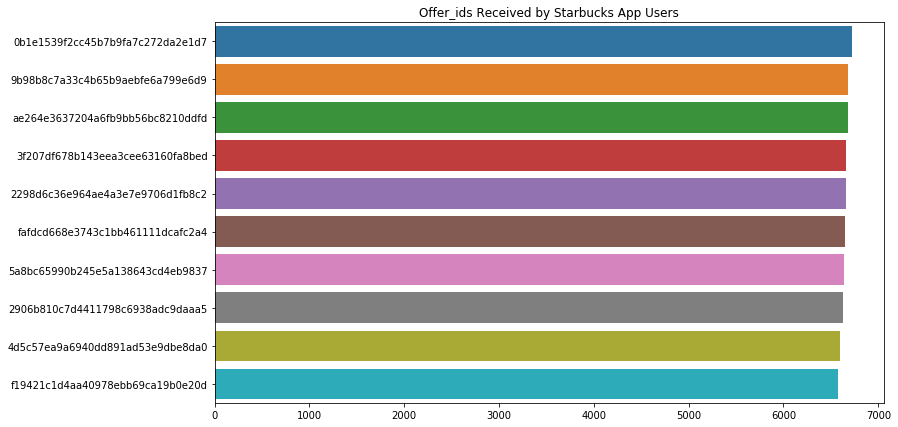

In [37]:
#count offer_ids that were received
received_offers = transcript[transcript['event']=='offer received']
received_offers['offer_id'].value_counts()
#plot the distribution of offer_ids received
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=received_offers, order = received_offers['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Offer_ids Received by Starbucks App Users')

From the graph, we see that offer id '0b1e1539f2cc45b7b9fa7c272da2e1d7' has the highest received status while offer id 'f19421c1d4aa40978ebb69ca19b0e20d' has the lowest received status.

Text(0.5,1,'Offer_ids Viewed by Starbucks App Users')

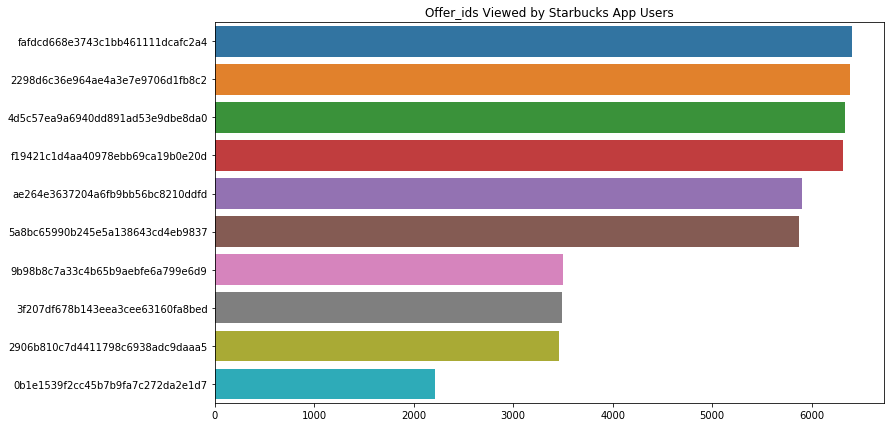

In [38]:
#count offer_ids that were viewed
viewed_offers = transcript[transcript['event']=='offer viewed']
viewed_offers['offer_id'].value_counts()
#plot the distribution of offer_ids viewed
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=viewed_offers, order = viewed_offers['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Offer_ids Viewed by Starbucks App Users')

From the graph, we see that offer id 'fafdcd668e3743c1bb461111dcafc2a4' has the highest viewed status while offer id '0b1e1539f2cc45b7b9fa7c272da2e1d7' has the lowest viewed status.

'fafdcd668e3743c1bb461111dcafc2a4' was a popular offer id for Starbucks users.In the next few codes, we shall examine its offer type by combining the portfolio and profile data to achieve this. 

## 3c. Merging the three datasets

In [39]:
#Merging transcript data with portfolio data to get the offer datails
transcript_new =transcript.merge(portfolio,how='left',on='offer_id')

#Merging with profile data on the basis of customer id
starbucks_dataset=transcript_new.merge(profile,how='left',on='customerid')


starbucks_dataset.head(10)

,customerid,event,time,amount,reward_x,offer_id,reward_y,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,start_year,membership_days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,168.0,bogo,1.0,1.0,1.0,0.0,F,75.0,100000.0,2017,1144
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,168.0,discount,1.0,1.0,1.0,0.0,M,68.0,70000.0,2018,792
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,M,65.0,53000.0,2018,868
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,0.0,96.0,informational,1.0,1.0,1.0,0.0,M,58.0,51000.0,2017,958
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,1.0,1.0,0.0,0.0,F,61.0,57000.0,2017,1019
5,31dda685af34476cad5bc968bdb01c53,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,1.0,1.0,0.0,0.0,F,62.0,71000.0,2016,1597
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,168.0,bogo,0.0,1.0,1.0,1.0,M,64.0,100000.0,2017,1021
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,0.0,96.0,informational,1.0,1.0,1.0,0.0,F,78.0,71000.0,2017,1106
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,1.0,1.0,0.0,0.0,F,88.0,53000.0,2017,1135
9,f806632c011441378d4646567f357a21,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,240.0,discount,1.0,1.0,1.0,1.0,M,42.0,69000.0,2013,2511


In [40]:
#Dropping reward_x and rename reward_y to reward
starbucks_dataset.drop(['reward_x'],axis=1,inplace=True)
starbucks_dataset.rename(columns={"reward_y": "reward"}, inplace = True)
starbucks_dataset.head(10)

,customerid,event,time,amount,offer_id,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,start_year,membership_days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,168.0,bogo,1.0,1.0,1.0,0.0,F,75.0,100000.0,2017,1144
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,168.0,discount,1.0,1.0,1.0,0.0,M,68.0,70000.0,2018,792
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,M,65.0,53000.0,2018,868
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,0.0,0.0,96.0,informational,1.0,1.0,1.0,0.0,M,58.0,51000.0,2017,958
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,1.0,1.0,0.0,0.0,F,61.0,57000.0,2017,1019
5,31dda685af34476cad5bc968bdb01c53,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,1.0,1.0,0.0,0.0,F,62.0,71000.0,2016,1597
6,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,168.0,bogo,0.0,1.0,1.0,1.0,M,64.0,100000.0,2017,1021
7,c27e0d6ab72c455a8bb66d980963de60,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,0.0,0.0,96.0,informational,1.0,1.0,1.0,0.0,F,78.0,71000.0,2017,1106
8,d53717f5400c4e84affdaeda9dd926b3,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,1.0,1.0,0.0,0.0,F,88.0,53000.0,2017,1135
9,f806632c011441378d4646567f357a21,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,240.0,discount,1.0,1.0,1.0,1.0,M,42.0,69000.0,2013,2511


In [41]:
#Creating dummy variables for events
dummies = pd.get_dummies(starbucks_dataset.event)
starbucks_dataset = pd.concat([starbucks_dataset, dummies], axis=1)
starbucks_dataset.drop(['event'],axis=1,inplace=True)
starbucks_dataset.head(10)
# Perform Encoding on the 'gender' column
starbucks_dataset['gender'] = starbucks_dataset["gender"].map({'M': 1, 'F': 0,'O':2})

Text(0.5,1,'Distribution of offer types received')

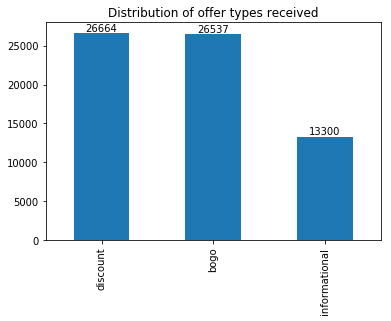

In [42]:
received = starbucks_dataset[starbucks_dataset['offer received']==1].offer_type.value_counts()
received.plot(kind='bar')
for i, typ in enumerate(received):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types received')

From the visualization above, we can see that users receives more discount and bogo offers than informational offers.

Text(0.5,1,'Distribution of offer types viewed')

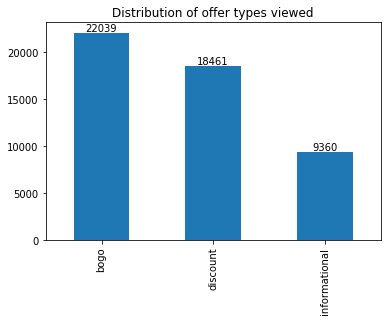

In [43]:
viewed= starbucks_dataset[starbucks_dataset['offer viewed']==1].offer_type.value_counts()
viewed.plot(kind='bar')
for i, typ in enumerate(viewed):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types viewed')

BOGO offers are viewed more than discount offers while informational offers are viewed the least. The reason is that users have more incentives to purchase Starbucks products with BOGO offers.

Text(0.5,1,'Distribution of offer types with completed status')

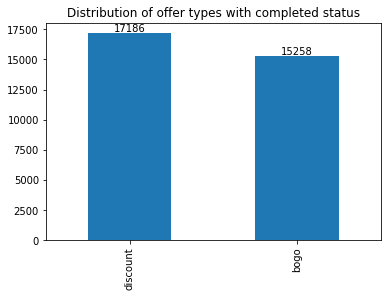

In [44]:
completed = starbucks_dataset[starbucks_dataset['offer completed']==1].offer_type.value_counts()
completed.plot(kind='bar')
for i, typ in enumerate(completed):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types with completed status')

Informational offers don't have completed status. Discount offers has the most completed status.

## 3d. Assumptions for creating the class variable
An offer is successfully completed if it follows the below sequence:

1. For informational offers:-

After the offer is received, it should be viewed within the validity period of the offer. Then, a customer should spend the required amount for the completion of that offer before the offer end time. Note, that transactions should be after the offer is viewed.


2. For Discount and BOGO offers:-

After the offer is received, it should be viewed within the validity period of the offer. There should be an offer completed entry where a customer should spend the required amount for the completion of that offer before the offer end time. Note, that transactions should be after the offer is viewed.


In [45]:
starbucks_dataset.columns

Index(['customerid', 'time', 'amount', 'offer_id', 'reward', 'difficulty',
       'duration', 'offer_type', 'web', 'email', 'mobile', 'social', 'gender',
       'age', 'income', 'start_year', 'membership_days', 'offer completed',
       'offer received', 'offer viewed', 'transaction'],
      dtype='object')

In [46]:
#Create a transaction data which contains only the transaction details.
transaction =transcript[transcript['event']=='transaction']
transaction= transaction[['customerid','time','amount']]
transaction = transaction.reset_index(drop=True)
transaction.head()

,customerid,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [47]:
starbucks_copy = starbucks_dataset.copy()

starbucks_copy = starbucks_copy[starbucks_copy.transaction == 0][['customerid', 'offer_id', 'offer received', 'offer viewed', 'offer completed', 'time','gender']]


#Re-encode time=0 with time=0.005 (a number close to 0) just to differentiate it from the no-event time.
starbucks_copy['time'] = starbucks_copy.time.replace(0, 0.005)
 
 #Create a unique identifier for each offer sent (because some offers were sent more than once to the same customer)
starbucks_copy['received_unique_id'] = starbucks_copy[starbucks_copy['offer received'] == 1].groupby(['customerid', 'offer_id']).cumcount()
starbucks_copy['viewed_unique_id'] = starbucks_copy[starbucks_copy['offer viewed'] == 1].groupby(['customerid', 'offer_id']).cumcount()
starbucks_copy['completed_unique_id'] = starbucks_copy[starbucks_copy['offer completed'] == 1].groupby(['customerid', 'offer_id']).cumcount()
starbucks_copy['events_unique_id'] = starbucks_copy[['received_unique_id', 'viewed_unique_id', 'completed_unique_id']].max(axis=1).values
starbucks_copy['unique_offer_id'] = starbucks_copy['offer_id'] + "-" + starbucks_copy['events_unique_id'].apply(lambda x: str(x))
 
#Create columns which captures the time for each event, such as time at which an offer was received, viewed etc

starbucks_copy['offer_received_time'] = starbucks_copy['offer received']*starbucks_copy.time
starbucks_copy['offer_viewed_time'] = starbucks_copy['offer viewed']*starbucks_copy.time
starbucks_copy['offer_completed_time'] = starbucks_copy['offer completed']*starbucks_copy.time
starbucks_copy = starbucks_copy[['customerid', 'unique_offer_id', 'offer_id','gender', 'time', 'offer_received_time', 'offer_viewed_time', 'offer_completed_time']]

#Unstack values to get to the level of each (customerid, offer_id) 
#Need to take max value to avoid 0s
starbucks_copy = starbucks_copy.groupby(by=['customerid', 'unique_offer_id', 'time']).max().unstack()
starbucks_copy.fillna(0, inplace=True)

#Create the final dataset which has details for each offer sent
starbucks_offers = pd.DataFrame(starbucks_copy.index.get_level_values('unique_offer_id'), starbucks_copy.index.get_level_values('customerid')).reset_index()
starbucks_offers['offer_received_time'] = starbucks_copy['offer_received_time'].values.max(axis=1)
starbucks_offers['offer_viewed_time'] = starbucks_copy['offer_viewed_time'].values.max(axis=1)
starbucks_offers['offer_completed_time'] = starbucks_copy['offer_completed_time'].values.max(axis=1)
starbucks_offers['gender'] = (starbucks_copy['gender'].values.max(axis=1))

#Add information about each offer from portfolio
starbucks_offers['offer_id'] = starbucks_offers.unique_offer_id.apply(lambda x: x.split("-")[0])
starbucks_offers = starbucks_offers.merge(portfolio, on='offer_id', how='left')

#Calculate offer end time by adding validity period for each offers to the offer received time
starbucks_offers['offer_end_time'] = starbucks_offers['offer_received_time']+starbucks_offers['duration']
 
#Create a flag variable to indicate whether the offer was viewed or not
starbucks_offers['viewed_flag'] = starbucks_offers.offer_viewed_time.apply(lambda x: 1 if x > 0 else 0)

#Create a flag variable to check whether the offer was viewed before the end time
starbucks_offers['viewed_on_time_flag'] = (starbucks_offers.offer_viewed_time < starbucks_offers.offer_end_time)*starbucks_offers['viewed_flag'] 

#Create a flag variable to check whether the offer was completed before the end time
starbucks_offers['completed_flag'] = starbucks_offers.offer_completed_time.apply(lambda x: 1 if x > 0 else 0)
starbucks_offers['completed_on_time_flag'] = (starbucks_offers.offer_completed_time < starbucks_offers.offer_end_time)*starbucks_offers['completed_flag'] 

#Valid completions should be the ones which are done after offer viewed and before the end period.
#Create a flag variable for identifying the valid completed offers.
completed_before_expires = (starbucks_offers.offer_completed_time < starbucks_offers.offer_end_time)
completed_after_viewing =(starbucks_offers.offer_completed_time > starbucks_offers.offer_viewed_time)*starbucks_offers['viewed_flag']
starbucks_offers['completed_valid'] = (completed_after_viewing & completed_before_expires)*starbucks_offers['completed_flag']

starbucks_offers.head()

,customerid,unique_offer_id,offer_received_time,offer_viewed_time,offer_completed_time,gender,offer_id,reward,difficulty,duration,...,web,email,mobile,social,offer_end_time,viewed_flag,viewed_on_time_flag,completed_flag,completed_on_time_flag,completed_valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,576.0,0.0,576.0,1.0,2906b810c7d4411798c6938adc9daaa5,2,10,168,...,1,1,1,0,744.0,0,0,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,336.0,372.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed,0,0,96,...,1,1,1,0,432.0,1,1,0,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,168.0,192.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837,0,0,72,...,0,1,1,1,240.0,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,408.0,456.0,414.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,...,1,1,1,1,528.0,1,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,504.0,540.0,528.0,1.0,fafdcd668e3743c1bb461111dcafc2a4,2,10,240,...,1,1,1,1,744.0,1,1,1,1,0


In [48]:
#Giving a very high value for the viewed time of the not viewed offers and 
# making the offer_completed_time for informational offers as the offer_end_time
starbucks_copy = starbucks_offers.copy()
starbucks_copy.loc[starbucks_copy.viewed_on_time_flag == 0, 'offer_viewed_time'] = 999
starbucks_copy['offer_completed_time']=np.where(starbucks_copy['offer_type'] == 'informational', starbucks_copy['offer_end_time'],starbucks_copy['offer_completed_time'])
starbucks_copy.head()

,customerid,unique_offer_id,offer_received_time,offer_viewed_time,offer_completed_time,gender,offer_id,reward,difficulty,duration,...,web,email,mobile,social,offer_end_time,viewed_flag,viewed_on_time_flag,completed_flag,completed_on_time_flag,completed_valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,576.0,999.0,576.0,1.0,2906b810c7d4411798c6938adc9daaa5,2,10,168,...,1,1,1,0,744.0,0,0,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,336.0,372.0,432.0,1.0,3f207df678b143eea3cee63160fa8bed,0,0,96,...,1,1,1,0,432.0,1,1,0,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,168.0,192.0,240.0,1.0,5a8bc65990b245e5a138643cd4eb9837,0,0,72,...,0,1,1,1,240.0,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,408.0,456.0,414.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,...,1,1,1,1,528.0,1,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,504.0,540.0,528.0,1.0,fafdcd668e3743c1bb461111dcafc2a4,2,10,240,...,1,1,1,1,744.0,1,1,1,1,0


In [49]:
# Define a function which creates offer details by looping through each offer_id for the 
# given customer and gives details about the success and failure of the offer
def create_customer_offer(customerid):
    '''
    Create offer details for the given customer
    Input : customerid -- customer id for the required customer
    Output : A dictionary containing the offer details for the given customer for all the offers received
            It will have column to indicate whether an offer was success or not
            
    '''    
    #Get details of the current customer
    current_customer = profile[profile['customerid'] == customerid]
    # Get offer details for the given customer
    select_offer_data = starbucks_copy['customerid'] == customerid
    customer_offer_data = starbucks_copy[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customerid')
    customer_offer_data = customer_offer_data.reset_index(drop=True)
    # Select transactions for a specific customer
    select_transaction = transaction['customerid'] == customerid
    customer_transaction = transaction[select_transaction]
    customer_transaction =customer_transaction.drop(columns='customerid')
    rows = []
    for idx in range(customer_offer_data.shape[0]):
        # Getting the current offer_id and offer_type
        current_offer_id = customer_offer_data.iloc[idx]['unique_offer_id']
        current_offer_type = customer_offer_data.iloc[idx]['offer_type']
        # Getting the details for current offer
        current_offer = customer_offer_data.loc[customer_offer_data['unique_offer_id'] == current_offer_id]
        current_offer_startime = customer_offer_data.iloc[idx]['offer_received_time']
        current_offer_endtime = customer_offer_data.iloc[idx]['offer_end_time']
        # Getting a boolean array for all the viewed offers that fall within the start and end period
        
        select_transaction = np.logical_and(customer_transaction['time'] >=
                                                customer_offer_data .loc[customer_offer_data ['unique_offer_id']==current_offer_id,'offer_viewed_time'].values[0], 
                                                customer_transaction['time'] <= customer_offer_data.loc[customer_offer_data ['unique_offer_id']==current_offer_id,'offer_completed_time'].values[0])
                                                 
        #Getting the valid transactions            
        current_offer_transactions = customer_transaction[select_transaction]
        # Determine whether the current offer was successful ie, If any offer is viewed and current 
        # transaction is greater than the difficulty required for that offer
        current_offer_successful = (current_offer_transactions['amount'].sum()>customer_offer_data.iloc[idx]['difficulty'])*customer_offer_data .iloc[idx]['viewed_on_time_flag']
        # Initialize a dictionary that describes the current customer offer
        current_row = {'customerid': customerid,
                   'unique_offer_id': current_offer_id,
                   'time': current_offer_startime,
                   'offersuccessful': int(current_offer_successful),
                   'total_amount': current_offer_transactions['amount'].sum() }
        current_row.update(current_offer.iloc[0,1:].to_dict())
        current_row.update(current_customer.iloc[0,1:].to_dict())
        # Update a list of dictionaries that describes the effectiveness of offers to a specific customer
        rows.append(current_row)
    return rows

In [50]:
Starbucks_data_clean = []
customer_list = list(starbucks_copy['customerid'].unique())
#Looping through each customer and for each customer looping through each order
for idx in range(len(customer_list)):
    Starbucks_data_clean.extend(create_customer_offer(customer_list[idx]))
Starbucks_data_clean = pd.DataFrame(Starbucks_data_clean)
#Initialize a list that describes the desired output DataFrame
    #Column ordering
column_ordering = ['time', 'customerid','unique_offer_id','offer_id', 'total_amount',
                       'offersuccessful', 'difficulty', 'duration', 'reward','age',
                       'offer_type','viewed_flag','viewed_on_time_flag','completed_flag','completed_on_time_flag','completed_valid','email', 'mobile', 'social', 'web', 
                       'income','membership_days','gender','start_year']

Starbucks_data_clean = Starbucks_data_clean[column_ordering]

Starbucks_data_clean = Starbucks_data_clean.sort_values('customerid')
Starbucks_data_clean.reset_index(drop=True)

,time,customerid,unique_offer_id,offer_id,total_amount,offersuccessful,difficulty,duration,reward,age,...,completed_on_time_flag,completed_valid,email,mobile,social,web,income,membership_days,gender,start_year
0,576.000,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,2906b810c7d4411798c6938adc9daaa5,0.00,0,10,168,2,33.0,...,1,0,1,1,0,1,72000.0,1162,1.0,2017
1,336.000,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,3f207df678b143eea3cee63160fa8bed,8.57,1,0,96,0,33.0,...,0,0,1,1,0,1,72000.0,1162,1.0,2017
2,168.000,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,5a8bc65990b245e5a138643cd4eb9837,22.16,1,0,72,0,33.0,...,0,0,1,1,1,0,72000.0,1162,1.0,2017
3,408.000,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0,5,120,5,33.0,...,1,0,1,1,1,1,72000.0,1162,1.0,2017
4,504.000,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0,10,240,2,33.0,...,1,0,1,1,1,1,72000.0,1162,1.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,408.000,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5-1.0,2906b810c7d4411798c6938adc9daaa5,17.55,1,10,168,2,45.0,...,1,0,1,1,0,1,62000.0,1309,0.0,2016
66497,504.000,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9-0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,5,168,5,45.0,...,1,0,1,1,0,1,62000.0,1309,0.0,2016
66498,168.000,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7-0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.88,1,20,240,5,45.0,...,1,1,1,0,0,1,62000.0,1309,0.0,2016
66499,336.000,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5-0.0,2906b810c7d4411798c6938adc9daaa5,15.57,1,10,168,2,45.0,...,1,1,1,1,0,1,62000.0,1309,0.0,2016


In [51]:
#Creating bins for age

bins = [0,20, 40, 60, 80, np.inf]
names = ['<20', '20-40', '40-60', '60-80', '80+']

Starbucks_data_clean['agerange'] = pd.cut(Starbucks_data_clean['age'], bins, labels=names)


#creating bins for Income
bins = [0,40000,60000, 80000,100000 ,np.inf]
names = ['<40K', '40K-60K', '60K-80K', '80K-100K','100K+']

Starbucks_data_clean['incomerange'] = pd.cut(Starbucks_data_clean['income'], bins, labels=names)
Starbucks_data_clean.head()

,time,customerid,unique_offer_id,offer_id,total_amount,offersuccessful,difficulty,duration,reward,age,...,email,mobile,social,web,income,membership_days,gender,start_year,agerange,incomerange
0,576.0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,2906b810c7d4411798c6938adc9daaa5,0.00,0,10,168,2,33.0,...,1,1,0,1,72000.0,1162,1.0,2017,20-40,60K-80K
1,336.0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,3f207df678b143eea3cee63160fa8bed,8.57,1,0,96,0,33.0,...,1,1,0,1,72000.0,1162,1.0,2017,20-40,60K-80K
2,168.0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,5a8bc65990b245e5a138643cd4eb9837,22.16,1,0,72,0,33.0,...,1,1,1,0,72000.0,1162,1.0,2017,20-40,60K-80K
3,408.0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0,5,120,5,33.0,...,1,1,1,1,72000.0,1162,1.0,2017,20-40,60K-80K
4,504.0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0,10,240,2,33.0,...,1,1,1,1,72000.0,1162,1.0,2017,20-40,60K-80K


Note that gender has been label encoded to numerical values where 0= Female, 1= Male and 2= Other 

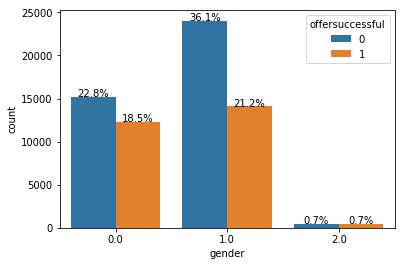

In [52]:
ax = sns.countplot(data=Starbucks_data_clean,
                  x = 'gender',
                 hue = 'offersuccessful')
total = float((Starbucks_data_clean.offersuccessful.count()))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format((height/total)*100),
            ha="center")

The Male demographic had more successful offers than the Female gender group. We will ignore the Other gender group since it does not have enough data to provide a clear decision. Hence, this means that Male users are more likely to respond to offers than their Female counterpart.

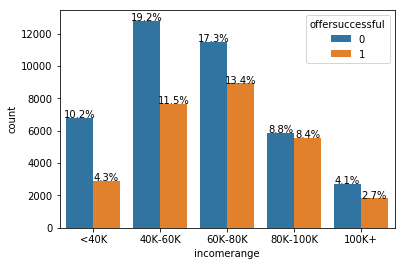

In [53]:
ax = sns.countplot(data=Starbucks_data_clean,
                  x = 'incomerange',
                 hue = 'offersuccessful')
total = float((Starbucks_data_clean.offersuccessful.count()))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format((height/total)*100),
            ha="center")

We see that the 60-80K income range has the most successful offers while the income range 100K+ has the least successful offers.

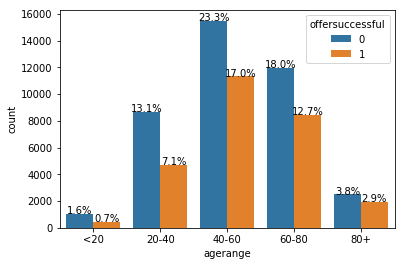

In [54]:
ax = sns.countplot(data=Starbucks_data_clean,
                  x = 'agerange',
                 hue = 'offersuccessful')
total = float((Starbucks_data_clean.offersuccessful.count()))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format((height/total)*100),
            ha="center")

We see that the 40-60 age range has the most successful offers while the age range <20 has the least successful offers.Teenage users may not consume much coffee compared to other age groups.

In [55]:
Starbucks_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   time                    66501 non-null  float64 
 1   customerid              66501 non-null  object  
 2   unique_offer_id         66501 non-null  object  
 3   offer_id                66501 non-null  object  
 4   total_amount            66501 non-null  float64 
 5   offersuccessful         66501 non-null  int64   
 6   difficulty              66501 non-null  int64   
 7   duration                66501 non-null  int64   
 8   reward                  66501 non-null  int64   
 9   age                     66501 non-null  float64 
 10  offer_type              66501 non-null  object  
 11  viewed_flag             66501 non-null  int64   
 12  viewed_on_time_flag     66501 non-null  int64   
 13  completed_flag          66501 non-null  int64   
 14  completed_on_time_flag

In [56]:
#create dummy variables for offer_type using one hot encoding
dummies = pd.get_dummies(Starbucks_data_clean. offer_type)
Starbucks_data_clean = pd.concat([Starbucks_data_clean, dummies], axis=1)

#drop the following variables that will not be needed during modeling
Starbucks_data_clean.drop(['offer_type','customerid','unique_offer_id','offer_id','agerange','incomerange'],axis=1,inplace=True)
Starbucks_data_clean.head(10)

,time,total_amount,offersuccessful,difficulty,duration,reward,age,viewed_flag,viewed_on_time_flag,completed_flag,...,mobile,social,web,income,membership_days,gender,start_year,bogo,discount,informational
0,576.000,0.00,0,10,168,2,33.0,0,0,1,...,1,0,1,72000.0,1162,1.0,2017,0,1,0
1,336.000,8.57,1,0,96,0,33.0,1,1,0,...,1,0,1,72000.0,1162,1.0,2017,0,0,1
2,168.000,22.16,1,0,72,0,33.0,1,1,0,...,1,1,0,72000.0,1162,1.0,2017,0,0,1
3,408.000,0.00,0,5,120,5,33.0,1,1,1,...,1,1,1,72000.0,1162,1.0,2017,1,0,0
4,504.000,0.00,0,10,240,2,33.0,1,1,1,...,1,1,1,72000.0,1162,1.0,2017,0,1,0
9,504.000,22.05,1,5,168,5,40.0,1,1,1,...,1,0,1,57000.0,899,2.0,2018,1,0,0
7,0.005,0.00,0,0,96,0,40.0,1,1,0,...,1,0,1,57000.0,899,2.0,2018,0,0,1
8,336.000,0.00,0,0,72,0,40.0,1,1,0,...,1,1,0,57000.0,899,2.0,2018,0,0,1
5,408.000,22.05,1,20,240,5,40.0,1,1,1,...,0,0,1,57000.0,899,2.0,2018,0,1,0
6,168.000,11.93,1,7,168,3,40.0,1,1,1,...,1,1,1,57000.0,899,2.0,2018,0,1,0


## 3e. Answers to Business Question 1 and 2
1) Determine which demographic groups, i.e.age, gender and income groups, respond best to the offer types.

The 40-60 age range, male, and the 60-80K income range respond best to offers.

2) Assess characteristics of the demographic groups who respond the least to offers.

The <20 age range, female and the 100+K income range respond the least to offers.

## 4. Data Preprocessing

The data preprocessing stage involves creating target and features variables. Our target variable is "offersuccessful". This indicates whether a user successfully responded to an offer or not.

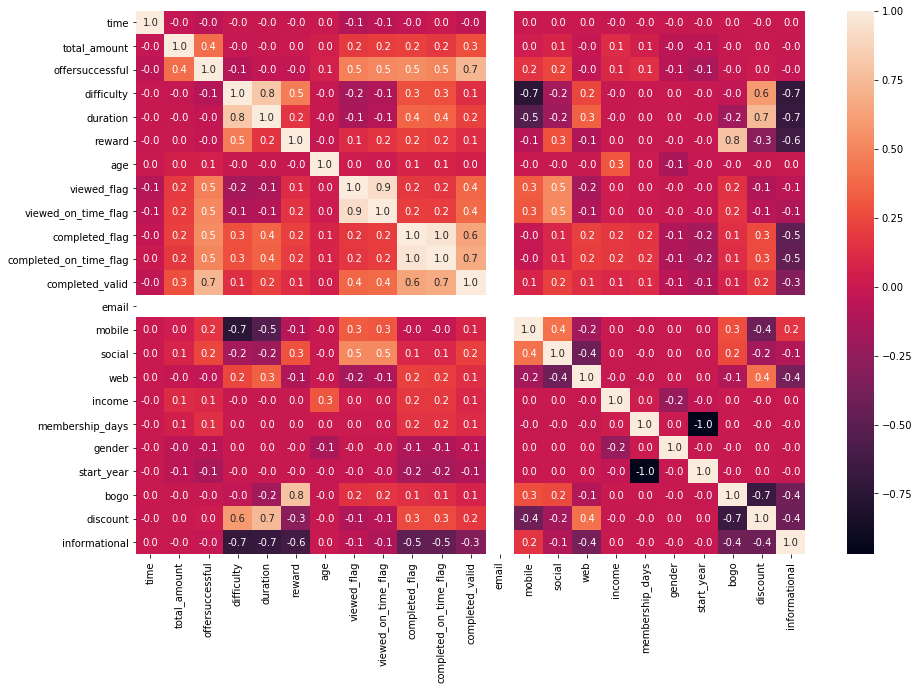

In [57]:
# In order to select the feature variables, we need to use the correlation matrix as a selection tool.
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Starbucks_data_clean.corr(), annot=True, fmt='.1f');

The correlation matrix suggest that the following are highly correlated at a co-efficient score greater than 0.6: viewed flag and viewed on time flag, start year and membership days, completed flag and completed on time flag, BOGO and reward, discount and duration, informational and duration, informational and difficulty, difficulty and mobile, difficulty and duration, BOGO and discount, offer successful and completed valid, completed on time flag and completed valid. We will be dropping the following  features:- start year, viewed flag, completed valid, reward, discount, informational, mobile, and completed flag.

In [58]:
#drop highly correlated variables
Starbucks_data_clean.drop(['start_year','reward','completed_flag','viewed_flag','mobile','informational','discount','completed_valid'],axis=1,inplace=True)
Starbucks_data_clean.head(10)

,time,total_amount,offersuccessful,difficulty,duration,age,viewed_on_time_flag,completed_on_time_flag,email,social,web,income,membership_days,gender,bogo
0,576.000,0.00,0,10,168,33.0,0,1,1,0,1,72000.0,1162,1.0,0
1,336.000,8.57,1,0,96,33.0,1,0,1,0,1,72000.0,1162,1.0,0
2,168.000,22.16,1,0,72,33.0,1,0,1,1,0,72000.0,1162,1.0,0
3,408.000,0.00,0,5,120,33.0,1,1,1,1,1,72000.0,1162,1.0,1
4,504.000,0.00,0,10,240,33.0,1,1,1,1,1,72000.0,1162,1.0,0
9,504.000,22.05,1,5,168,40.0,1,1,1,0,1,57000.0,899,2.0,1
7,0.005,0.00,0,0,96,40.0,1,0,1,0,1,57000.0,899,2.0,0
8,336.000,0.00,0,0,72,40.0,1,0,1,1,0,57000.0,899,2.0,0
5,408.000,22.05,1,20,240,40.0,1,1,1,0,1,57000.0,899,2.0,0
6,168.000,11.93,1,7,168,40.0,1,1,1,1,1,57000.0,899,2.0,0


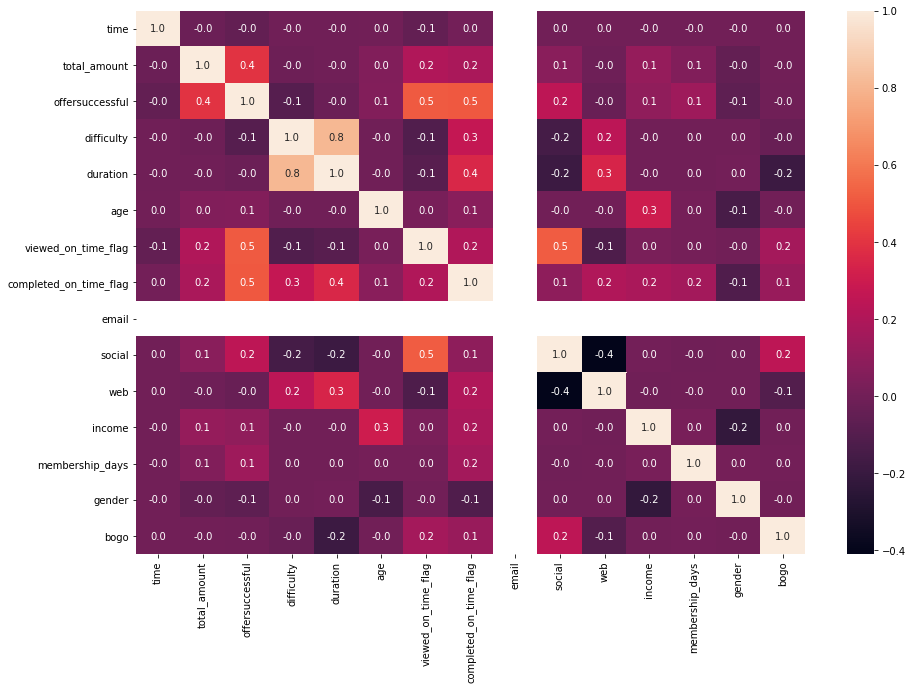

In [59]:
#check the correlation correlation matrix again
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Starbucks_data_clean.corr(), annot=True, fmt='.1f');

In [60]:
#we will drop duration as it is highly correlated with difficulty
Starbucks_data_clean.drop(['duration'],axis=1,inplace=True)
Starbucks_data_clean.head(10)

,time,total_amount,offersuccessful,difficulty,age,viewed_on_time_flag,completed_on_time_flag,email,social,web,income,membership_days,gender,bogo
0,576.000,0.00,0,10,33.0,0,1,1,0,1,72000.0,1162,1.0,0
1,336.000,8.57,1,0,33.0,1,0,1,0,1,72000.0,1162,1.0,0
2,168.000,22.16,1,0,33.0,1,0,1,1,0,72000.0,1162,1.0,0
3,408.000,0.00,0,5,33.0,1,1,1,1,1,72000.0,1162,1.0,1
4,504.000,0.00,0,10,33.0,1,1,1,1,1,72000.0,1162,1.0,0
9,504.000,22.05,1,5,40.0,1,1,1,0,1,57000.0,899,2.0,1
7,0.005,0.00,0,0,40.0,1,0,1,0,1,57000.0,899,2.0,0
8,336.000,0.00,0,0,40.0,1,0,1,1,0,57000.0,899,2.0,0
5,408.000,22.05,1,20,40.0,1,1,1,0,1,57000.0,899,2.0,0
6,168.000,11.93,1,7,40.0,1,1,1,1,1,57000.0,899,2.0,0


In [61]:
random_state = 42

class_label_name = 'offersuccessful'

variables = Starbucks_data_clean.drop(columns=[class_label_name])
class_label = Starbucks_data_clean.filter([class_label_name])

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(variables.values,
                            class_label.values,
                            test_size=0.2,
                            random_state=random_state)

variable_names = variables.columns

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

In [62]:
variables_to_scale = ['difficulty', 'age', 'total_amount','time', 'income','membership_days']

min_max_scaler = {}

for idx in range(len(variables_to_scale)):
    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    
    cur_column = variables_to_scale[idx]
    
    min_max_scaler[cur_column] = MinMaxScaler()
    min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))

    transformed_values =\
        min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))

    X_train[:, column_idx] = transformed_values.reshape(1, -1)
    
    transformed_values =\
        min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))

    X_test[:, column_idx] = transformed_values.reshape(1, -1)

## 5. Implementation
We will examine three classifiers to determine the best model, which will be futher improved to obtain the best estimator.

1) Logistic Regression 

2) Random Forest

3) XGBoost

In [63]:
# Creating a model directory to store model results
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score,
                     beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,
                                solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   14.2s finished


In [66]:
import re
# Create a def function to evaluate model performance
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [67]:

evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

LogisticRegression model accuracy: 0.991
LogisticRegression model f1-score: 0.989


(0.9909022556390977, 0.988724256826018)

In [68]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   40.2s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  5.3min finished


In [69]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 1.000
RandomForestClassifier model f1-score: 1.000


(0.9999624060150376, 0.9999534840450275)

Text(0.5,1,'Random Forest Estimated Feature Importance')

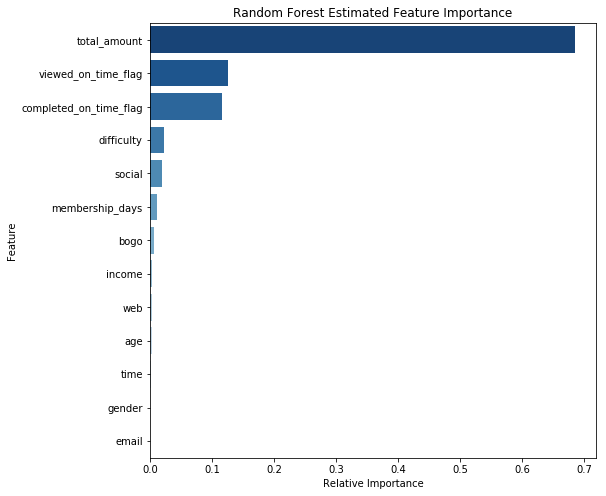

In [70]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [71]:
feature_importance.head(n=10)

,feature,relativeimportance
0,total_amount,0.684767
1,viewed_on_time_flag,0.125455
2,completed_on_time_flag,0.116143
3,difficulty,0.023534
4,social,0.018932
5,membership_days,0.012222
6,bogo,0.006241
7,income,0.003862
8,web,0.003754
9,age,0.003094


In [74]:
xgb_model_path = os.path.join(model_dir, 'xgb_clf.joblib')

if os.path.exists(xgb_model_path):
    xgb_random = load(xgb_model_path)
else:
    xgb_clf = XGBClassifier(random_state=random_state)

    # Create the random grid
    random_grid = {'booster': ['gbtree', 'dart'],
                   'learning_rate': [0.1, 0.01, 0.001,0.2],
                   'max_depth': [3, 4, 5, 6, 7],
                   'reg_lambda': [0, 1e-4, 1e-2, 1]}
                  

    xgb_random = RandomizedSearchCV(estimator = xgb_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    xgb_random.fit(X_train, y_train)

    dump(xgb_random, xgb_model_path)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   45.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  6.0min finished


In [75]:
evaluate_model_performance(xgb_random.best_estimator_,
                           X_train,
                           y_train)

XGBClassifier model accuracy: 1.000
XGBClassifier model f1-score: 1.000


(1.0, 1.0)

## 6. Refinement
Tune the final model

In [76]:
# Tuning the final model
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [77]:
grid_fit_path = os.path.join(model_dir, 'grid_fit.joblib')

if os.path.exists(grid_fit_path):
    grid_fit = load(grid_fit_path)
else:
    parameters = {'n_estimators': [10, 50, 100, 15, 5],
                  'max_depth': [10, 11, 12, 13, 14, 15],
                  'min_samples_leaf': [1, 2, 3, 4, 5],
                  'min_samples_split': [1, 2, 3, 4, 5],
                  'random_state': [random_state]}

    grid_obj = GridSearchCV(rf_clf,
                            parameters,
                            scoring=scorer,
                            cv=5,
                            n_jobs=3,
                            verbose=2)

    grid_fit = grid_obj.fit(X_train,
                            y_train)

    dump(grid_fit, grid_fit_path)

# Get the estimator
best_clf = grid_fit.best_estimator_

evaluate_model_performance(best_clf,
                           X_train,
                           y_train)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  39 tasks      | elapsed:   11.0s
[Parallel(n_jobs=3)]: Done 162 tasks      | elapsed:   52.9s
[Parallel(n_jobs=3)]: Done 377 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 669 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 1046 tasks      | elapsed:  6.0min
[Parallel(n_jobs=3)]: Done 1500 tasks      | elapsed:  9.1min
[Parallel(n_jobs=3)]: Done 2057 tasks      | elapsed: 12.4min
[Parallel(n_jobs=3)]: Done 2685 tasks      | elapsed: 16.0min
[Parallel(n_jobs=3)]: Done 3383 tasks      | elapsed: 19.9min
[Parallel(n_jobs=3)]: Done 3750 out of 3750 | elapsed: 22.0min finished


RandomForestClassifier model accuracy: 1.000
RandomForestClassifier model f1-score: 1.000


(0.9999248120300752, 0.9999069724173217)

## 7. Model Evaluation and Validation

In [79]:
#evaluate test data performance
evaluate_model_performance(best_clf,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 1.000
RandomForestClassifier model f1-score: 1.000


(0.999699270731524, 0.9996267263904441)

In [78]:
#print the best random forest parameters
best_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## 8. Justification
I selected random forest as the final model. Both random forest and XGboost had very similar accuracy and F1-score. Since the data is not highly imbalanced, both models produced very similar result. The most important features that were greater than 0.005 and influential in the model are:

- The transaction amount<br>
- An indicator that an offer was viewed during the validity period<br>
- An indicator that an offer was completed during the validity period<br>
- The minimum required spend to complete an offer<br>
- A BOGO offer <br>
- The social media channel<br>
- The number of days since the customer created an app account<br>

The influential features are intuitive, I can understand why they play a role in determining whether a customer responds to an offer or not.


## 9. Conclusion
The project was interesting and difficult because of the nature of the data. The simulated data mimics customer behavior on the Starbucks rewards mobile app, it will be interesting to compare the performance of the simulated data used in this project with real life data. The project involved cleaning, visualizing, exploring, modeling, evaluating , tuning and validating the data.

In summary, here are the insights from the data:-

- The 40-60 age range, Male, and the 60-80K income range respond best to offers
- BOGO was the most significant offer type that determined the success of an offer
- The total amount of a transaction plays a key role in determining whether a customer responds to an offer or not
- Social media was the most significant channel that determined the success of an offer
- The minimum required spend to complete an offer and membership days also determines the success of an offer
- The <20 age range, Female and the 100+K income range respond the least to offers

### Further studies/Improvement
Building a Regression Model to predict the magnitude of how transaction amount,income, age, difficulty, and membership days affects the success of an offer. One can explore the label differences in the categorical variables such as income, age, gender etc. These changes can be deployed to the web.
